In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import re
import warnings
warnings.filterwarnings("ignore")

#Upload Data & Cleanse

In [2]:
HUC12 = pd.read_csv("https://github.com/baileymccluresinger/PUS2024_BSinger/blob/main/Project/Nitrogen/nitrogen_HUC12.csv?raw=true")

station_names = pd.read_csv("https://github.com/baileymccluresinger/PUS2024_BSinger/blob/main/Project/Nitrogen/station_names.csv?raw=true")

nitro = pd.read_csv("https://github.com/baileymccluresinger/PUS2024_BSinger/blob/main/Project/Nitrogen/nitrogen_data.csv?raw=true")
nitro = nitro.iloc[::2]
nitro = nitro.reset_index(drop=True) # drop rows with numeric value in Station column

tidal = pd.read_csv("https://github.com/baileymccluresinger/PUS2024_BSinger/blob/main/Project/Condition_of_Tidal_Wetlands_20241009.csv?raw=true")
tidal = tidal.rename(columns={'Final score': 'Total Score'})
tidal = tidal.loc[:, ['Site Number', 'Date', 'Classification', 'Purpose', 'Watershed', 'Sub-watershed', 'Total Score']]

nontidal = pd.read_csv("https://github.com/baileymccluresinger/PUS2024_BSinger/blob/main/Project/Condition_of_Non-Tidal_Wetlands_20241009.csv?raw=true")
nontidal = nontidal.loc[:, ['Site Number', 'Date', 'Classification', 'Purpose', 'Watershed', 'Sub-watershed', 'Total Score']]

WetlandData = pd.concat([nontidal, tidal], ignore_index=True)

# **1. Clean up dataframe**

In [3]:
nitro[['Date_2', 'Time_2']] = nitro['Date'].str.split(' ', expand=True)
nitro['Year'] = nitro['Date_2'].str.slice(-4,)
nitro['Month'] = nitro['Date_2'].str.slice(0,2)
nitro['Month'] = nitro['Month'].str.replace('/', '')

nitro.drop('Date_2', axis=1, inplace=True)
nitro.drop('Time_2', axis=1, inplace=True)
nitro = nitro.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
#nitro.head(20)

In [4]:
WetlandData['Year'] = WetlandData['Date'].str.slice(-4,)
WetlandData['Month'] = WetlandData['Date'].str.slice(0,2)
WetlandData['Month'] = WetlandData['Month'].str.replace('/', '')
#WetlandData.head(20)

# **2. Assign row to HUC watershed**

In [5]:
# remove whitespaces
station_names = station_names.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# convert to dictionary and drop nan
station_names_reindexed = station_names.set_index('Nitrogen_Station')
stations_dict = station_names_reindexed.to_dict(orient='index')
for key, value in stations_dict.items():
    stations_dict[key] = {k: v for k, v in value.items() if not pd.isna(v)}

# combine values into list
stations_dict_2 = {}
for station in station_names["Nitrogen_Station"]:
  s_dict = stations_dict.get(station)
  values_list = list(s_dict.values())
  stations_dict_2[station] = values_list

watersheds = []
for i in range(0,len(nitro)):
  if not stations_dict_2[nitro["Station"][i]]:
    watersheds.append('')
  else:
    watersheds.append(stations_dict_2[nitro["Station"][i]][0])
nitro['Sub-watershed'] = watersheds

nitro['Sub-watershed'].replace('', np.nan, inplace=True)
nitro.dropna(subset=['Sub-watershed'], inplace=True);

In [6]:
data_final = pd.DataFrame() #Use only one measure for each station
stations = nitro["ID"].unique()
for i in range(0, len(stations)):
  new_row = nitro[nitro["ID"] == stations[i]]
  data_final = data_final._append(new_row.iloc[0], ignore_index=True)

data_final_2 = pd.DataFrame() #Use only one stations within the same watershed if more than one
sheds = data_final["Sub-watershed"].unique()
for i in range(0, len(sheds)):
  new_row = data_final[data_final["Sub-watershed"] == sheds[i]]
  data_final_2 = data_final_2._append(new_row.iloc[0], ignore_index=True)

In [7]:
synonyms = {
    'shellpot creek': ['shellpot creek', 'matson run-shellpot creek', 'shellpot'],
    'c&d canal east': ['c&d canal east', 'c&d canal east-delaware river'],
    'c&d canal west-back creek': ['c&d canal - west-back creek'],
    'little assawoman bay': ['little assawoman', 'little assawoman bay'],
    'lower leipsic river': ['lower leipsic river', 'lower lepsic river'],
    'lower mispillion river': ['lower mispillion river', 'lower missipillion river'],
    'appoquinimink river': [
        'appoqiunimick river',
        'drawyer creek-appoquinimink river',
        'appoquinimink river',
        'appoqunimick river'],
    'indian river': [
        'white creek-indian river bay',
        'indian river bay-indian river inlet',
        'indian river',
        'indian river bay',
        'buntings branch',
        'iron branch'],
    'rehoboth canal-rehoboth bay': [
        'rehoboth bay',
        'lewes rehoboth bay',
        'lewes-rehoboth canal'],
    'raccoon creek' : ['racoon creek'],
    'red lion creek' :['red lion creek-delaware river'],
    'middle branch white clay creek' :['white clay creek'],
    'chapel branch-choptank river' : ['chapel branch- choptank river'],
    'little creek-broad creek' : [
        'little creek',
        'smyrna river'],
    'broad duke canal-delaware river' : ['broad dyke'],
    'simons river-delaware bay' : ['simons river'],
    'brockonbridge gut-delaware bay' : ['brockonbridge gut'],
    'little river-delaware bay' : ['little river'],
    'cedar swamp-delaware bay' :['cedar swamp'],
    'murderkill river-town of south bowers' : ['murderkill river'],
    'grecos canal-delaware bay' : ['grecos canal'],
    'lower saint jones river' : ['lower st. jones river'],
    'beaverdam creek-broadkill river' :['beaverdam creek'],
    'canary creek-broadkill river' : ['canary creek'],
    'spring  creek' : ['spring creek',],
    'middle brandywine creek' : ['brandywine'],
    'dragon creek-delaware river' :['dragon creek'],
    'army creek-delaware river' : ['army creek']
}


def apply_synonyms(name, synonym_dict):
    for standard, variants in synonym_dict.items():
        if name.strip().lower() in (variant.strip().lower() for variant in variants):
            return standard
    return name

def clean_df(df, colName, synonym_dict):
     df[colName] = df[colName].fillna('').astype(str).str.lower().str.strip()
     df[colName] = df[colName].apply(lambda x: apply_synonyms(x, synonym_dict))


clean_df(WetlandData, 'Sub-watershed', synonyms)
clean_df(HUC12, 'Sub-watershed', synonyms)


In [8]:
WetlandData_2018 = WetlandData[WetlandData['Year'] == '2018']

print(WetlandData.info())
print(WetlandData_2018.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Site Number     1552 non-null   object 
 1   Date            1550 non-null   object 
 2   Classification  1128 non-null   object 
 3   Purpose         1552 non-null   object 
 4   Watershed       1552 non-null   object 
 5   Sub-watershed   1552 non-null   object 
 6   Total Score     1552 non-null   float64
 7   Year            1550 non-null   object 
 8   Month           1550 non-null   object 
dtypes: float64(1), object(8)
memory usage: 109.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 242 to 1175
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Site Number     81 non-null     object 
 1   Date            81 non-null     object 
 2   Classification  81 non-null     object 
 3   Purpose  

# **5. Combine with HUC dataset**

In [9]:
# Construct the query URL for the API - gave chatgbt the API and asked how to load it
Urbanurl = "https://enterprise.firstmap.delaware.gov/arcgis/rest/services/Society/DE_Census_2020/FeatureServer/12/query"
Boundaryurl = "https://enterprise.firstmap.delaware.gov/arcgis/rest/services/Boundaries/DE_Boundaries/FeatureServer/4/query"
watershedsurl = "https://enterprise.firstmap.delaware.gov/arcgis/rest/services/Hydrology/DE_Watersheds/MapServer/5/query"

params = {
    'where': '1=1',
    'outFields': '*',
    'outSR': '4326',
    'f': 'geojson'
}

Urbanresponse = requests.get(Urbanurl, params=params)
Boundaryresponse = requests.get(Boundaryurl, params=params)
watershedresponse = requests.get(watershedsurl, params=params)


Urbangdf = gpd.GeoDataFrame.from_features(Urbanresponse.json(), crs='EPSG:4326')
Boundarygdf = gpd.GeoDataFrame.from_features(Boundaryresponse.json(), crs='EPSG:4326')
watershedgdf = gpd.GeoDataFrame.from_features(watershedresponse.json(), crs='EPSG:4326')

In [10]:
#Clip
Boundary_geom = Boundarygdf.geometry.union_all()
Clipped_Urbangdf = gpd.clip(Urbangdf, Boundary_geom)
Clipped_Watershedgdf = gpd.clip(watershedgdf, Boundary_geom)

<Axes: >

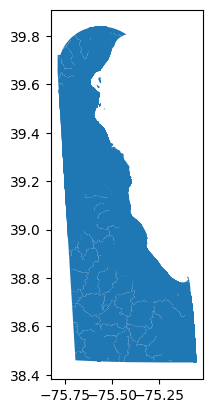

In [11]:
for df in [HUC12, WetlandData, data_final_2]:
    df['Sub-watershed'] = df['Sub-watershed'].str.lower().str.strip()


HUC12_gdf = Clipped_Watershedgdf.merge(HUC12[['OBJECTID','Sub-watershed']], on='OBJECTID', how='left')
wetlands_gdf = HUC12_gdf.merge(WetlandData, on='Sub-watershed', how='outer')
wetNitro_gdf = wetlands_gdf.merge(data_final_2, on='Sub-watershed', how='outer')

wetNitro_gdf.plot()

## **NITROGEN**

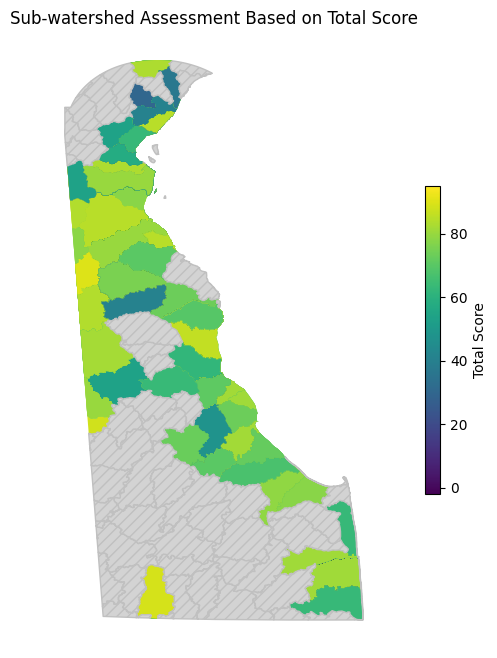

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

wetNitro_gdf.plot(ax=ax, column='Total Score', cmap='viridis', legend=True,
                  legend_kwds={'shrink': 0.5, 'label': 'Total Score'},
                  missing_kwds={'color': 'lightgrey', 'edgecolor': 'silver', 'hatch': '///', 'label': 'No data'})

plt.title('Sub-watershed Assessment Based on Total Score')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('off')
plt.show()

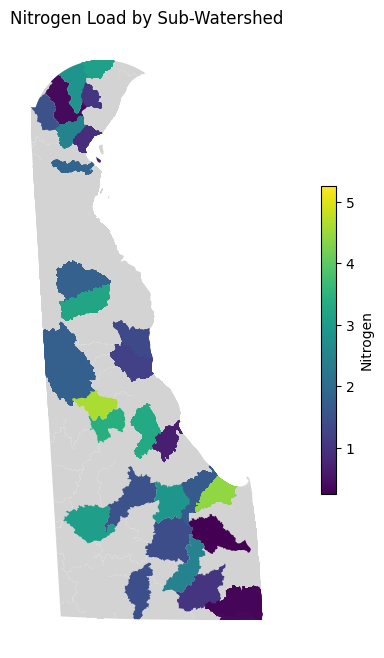

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
wetNitro_gdf.plot(ax=ax, color='lightgrey')
wetNitro_gdf.plot(ax=ax, column='N', cmap='viridis', legend=True,
                  legend_kwds={'shrink': 0.5, 'label': 'Nitrogen'})


plt.title('Nitrogen Load by Sub-Watershed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('off')
plt.show()

## **PH**

In [14]:
vars = ["TSS","DO",	"P",	"Sal",	"Temp",	"pH"]

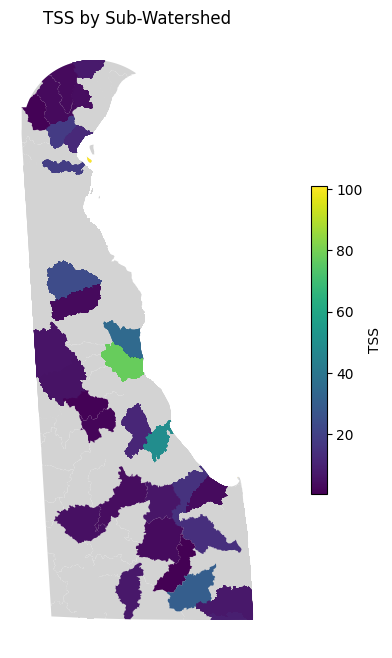

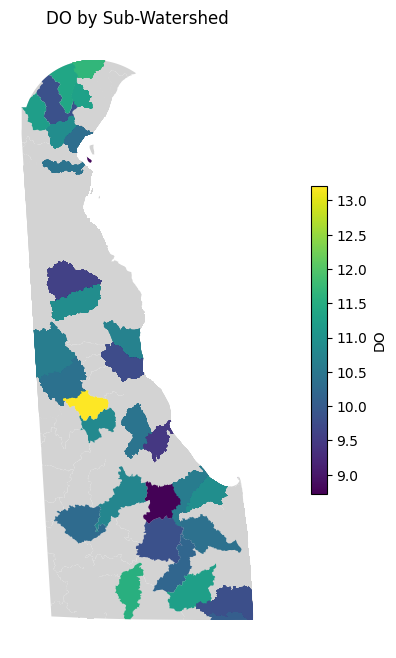

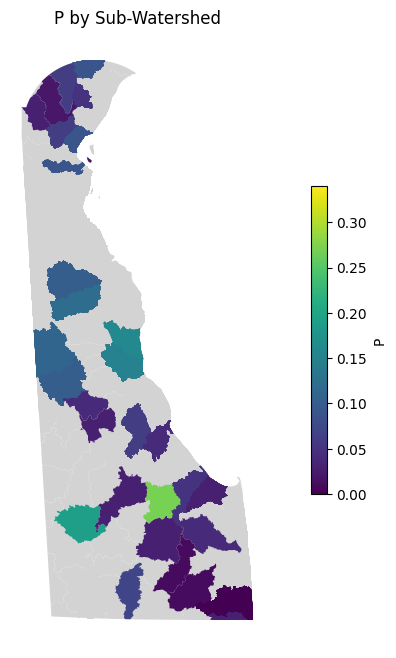

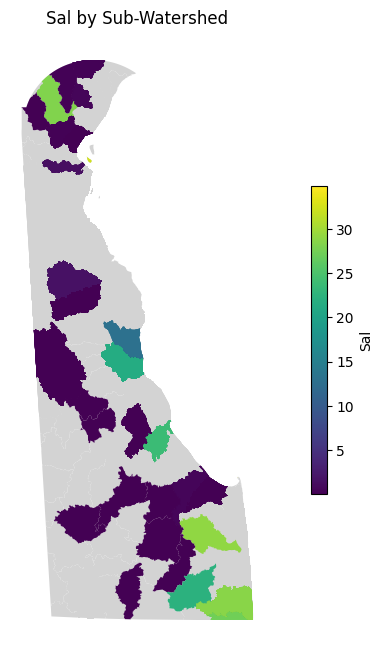

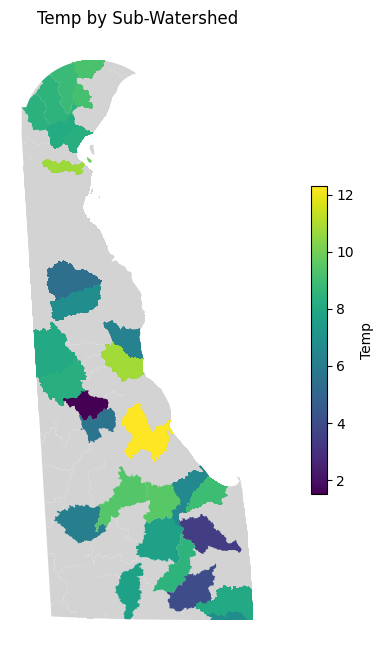

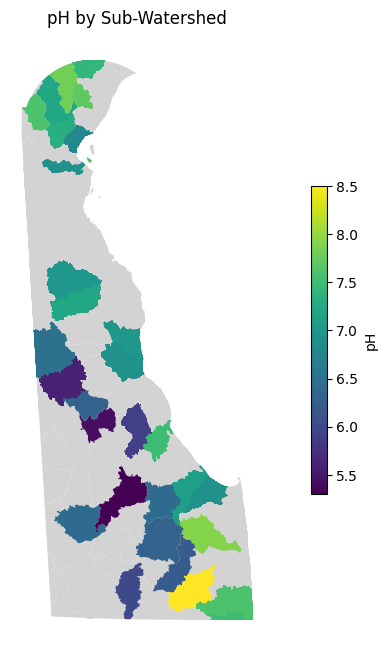

In [15]:
for var in vars:
  fig, ax = plt.subplots(1, 1, figsize=(12, 8))
  wetNitro_gdf.plot(ax=ax, color='lightgrey')
  wetNitro_gdf.plot(ax=ax, column=var, cmap='viridis', legend=True,
                    legend_kwds={"shrink":0.5,'label': var})


  plt.title(f'{var} by Sub-Watershed')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.axis('off')
  plt.show()

# **6. Save data**

In [16]:
wetNitro_gdf.to_csv('wetNitro_HUC12.csv', index=False)

# **Analysis**

## Urban population

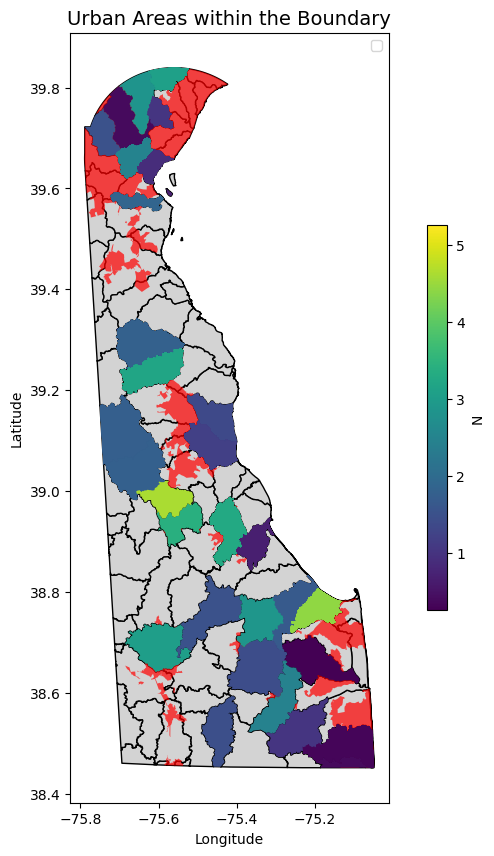

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

Clipped_Watershedgdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1, label='Boundary')
Clipped_Urbangdf.plot(ax=ax, color='red', alpha=0.7, label='Urban Area')
wetNitro_gdf.plot(ax=ax, column='N', cmap='viridis', legend=True, legend_kwds={"shrink":0.5,'label': 'N'})

plt.legend(loc='upper right')
plt.title('Urban Areas within the Boundary', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [18]:
# Drop rows with missing geometries
wetNitro_gdf = wetNitro_gdf[wetNitro_gdf.geometry.notna()]
Clipped_Urbangdf = Clipped_Urbangdf[Clipped_Urbangdf.geometry.notna()]


wetNitro_gdf['geometry'] = wetNitro_gdf['geometry'].apply(lambda geom: geom if geom.is_valid else geom.buffer(0))
Clipped_Urbangdf['geometry'] = Clipped_Urbangdf['geometry'].apply(lambda geom: geom if geom.is_valid else geom.buffer(0))

wetNitro_gdf['distance_to_urban'] = wetNitro_gdf.geometry.apply(
    lambda x: Clipped_Urbangdf.distance(x).min()
)


In [19]:
correlation = wetNitro_gdf[['N', 'distance_to_urban']].corr()
print(correlation)


                          N  distance_to_urban
N                  1.000000          -0.040088
distance_to_urban -0.040088           1.000000


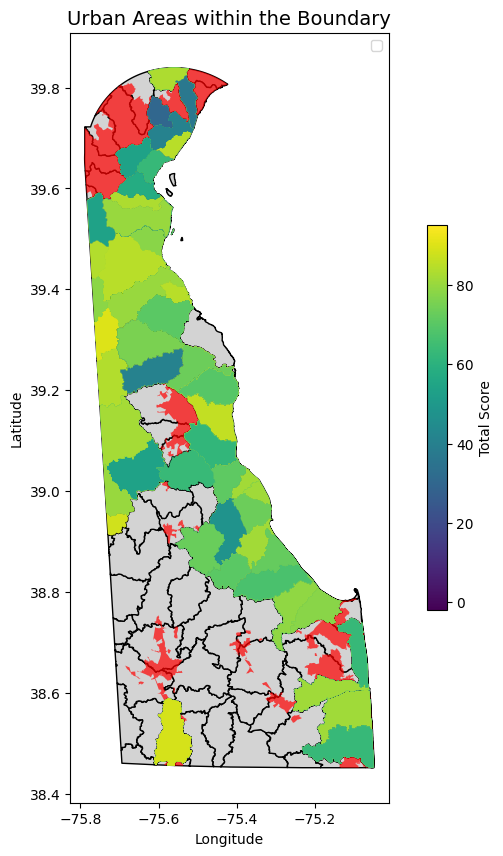

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

Clipped_Watershedgdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1, label='Boundary')
Clipped_Urbangdf.plot(ax=ax, color='red', alpha=0.7, label='Urban Area')
wetNitro_gdf.plot(ax=ax, column='Total Score', cmap='viridis', legend=True,
                  legend_kwds={'shrink': 0.5, 'label': 'Total Score'})

plt.legend(loc='upper right')
plt.title('Urban Areas within the Boundary', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [21]:
wetNitro_gdf['distance_to_urban'] = wetNitro_gdf.geometry.apply(
    lambda x: Clipped_Urbangdf.distance(x).min()
)

correlation = wetNitro_gdf[['Total Score', 'distance_to_urban']].corr()
print(correlation)


                   Total Score  distance_to_urban
Total Score           1.000000           0.187747
distance_to_urban     0.187747           1.000000


## Descriptive Statistics

In [22]:
overlap = pd.read_csv("https://raw.githubusercontent.com/baileymccluresinger/PUS2024_BSinger/refs/heads/main/Project/overlap.csv")
overlap

,Total Score,N,AREAACRES,AREASQKM,STATES,HUC12,NAME,Sub-watershed,Date_x,Watershed,...,TSS,DO,P,ENT,Sal,Temp,pH,CHL_A,Year_y,Month_y
0,71.66,4.43,13414.0,54.284580,DE,2.040207e+10,Canary Creek-Broadkill River,canary creek-broadkill river,7/28/2010,Broadkill,...,3.5,10.92,0.03,145,0.14,8.9,6.9,3.56,2023,12
1,85.55,4.43,13414.0,54.284580,DE,2.040207e+10,Canary Creek-Broadkill River,canary creek-broadkill river,7/28/2010,Broadkill,...,3.5,10.92,0.03,145,0.14,8.9,6.9,3.56,2023,12
2,81.66,4.43,13414.0,54.284580,DE,2.040207e+10,Canary Creek-Broadkill River,canary creek-broadkill river,7/23/2010,Broadkill,...,3.5,10.92,0.03,145,0.14,8.9,6.9,3.56,2023,12
3,79.99,4.43,13414.0,54.284580,DE,2.040207e+10,Canary Creek-Broadkill River,canary creek-broadkill river,7/26/2010,Broadkill,...,3.5,10.92,0.03,145,0.14,8.9,6.9,3.56,2023,12
4,65.50,4.43,13414.0,54.284580,DE,2.040207e+10,Canary Creek-Broadkill River,canary creek-broadkill river,7/29/2010,Broadkill,...,3.5,10.92,0.03,145,0.14,8.9,6.9,3.56,2023,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,55.56,2.50,9064.0,36.680739,DE,2.040205e+10,Middle Christina River,middle christina river,9/1/2011,Christina,...,17.9,10.91,0.06,409,0.32,8.1,7.3,3.23,2023,12
134,85.56,2.50,9064.0,36.680739,DE,2.040205e+10,Middle Christina River,middle christina river,9/9/2011,Christina,...,17.9,10.91,0.06,409,0.32,8.1,7.3,3.23,2023,12
135,87.00,3.64,NaN,NaN,NaN,NaN,NaN,raccoon creek,7/3/2019,Brandywine,...,6.8,10.08,0.34,4840,0.20,6.4,5.4,3.01,2023,12
136,66.00,3.64,NaN,NaN,NaN,NaN,NaN,raccoon creek,8/6/2019,Brandywine,...,6.8,10.08,0.34,4840,0.20,6.4,5.4,3.01,2023,12


In [23]:
TS_ave = pd.read_csv("https://raw.githubusercontent.com/baileymccluresinger/PUS2024_BSinger/refs/heads/main/Project/Subwatershed_TS_ave.csv")
TS_ave

,Total Score,N,Sub-watershed,Watershed,Station,TSS,DO,P,ENT,Sal,Temp,pH,CHL_A
0,77.425385,4.43,canary creek-broadkill river,Broadkill,Broadkill River,3.5,10.92,0.03,145,0.14,8.9,6.9,3.56
1,76.833333,1.77,cow marsh creek,Upper Choptank River,Cow Marsh Creek,5.3,10.39,0.10,107,0.05,8.3,5.6,1.57
2,76.222222,1.87,dragon creek-delaware river,Red Lion Creek,Dragon Creek,18.2,10.43,0.09,372,1.39,10.7,6.9,4.46
3,47.660000,0.32,little assawoman bay,Inland Bays,Little Assawoman Bay,7.0,9.80,0.00,5,28.66,8.0,7.6,7.03
4,48.175714,1.03,little mill creek,Christina,Little Mill Creek,3.7,11.27,0.05,922,0.50,9.1,7.7,2.89
5,71.941667,0.67,lower cedar creek,Mispillion,Cedar Creek,49.5,9.44,0.04,74,23.73,12.3,7.5,12.70
6,73.910000,1.19,lower saint jones river,St. Jones,St. Jones River,77.7,9.74,0.15,259,21.47,10.8,6.9,9.41
7,67.930909,2.50,middle christina river,Christina,Christina River near Conrail Bridge,17.9,10.91,0.06,409,0.32,8.1,7.3,3.23
8,74.333333,3.64,raccoon creek,Brandywine,Raccoon Prong,6.8,10.08,0.34,4840,0.20,6.4,5.4,3.01


In [24]:
overlap.describe()

,Total Score,N,AREAACRES,AREASQKM,HUC12,Year_x,Month_x,TSS,DO,P,ENT,Sal,Temp,pH,CHL_A,Year_y,Month_y
count,138.000000,138.000000,135.000000,135.000000,1.350000e+02,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,69.976087,1.625000,15411.407407,62.367808,2.042857e+10,2010.934783,7.275362,37.187681,10.139638,0.094275,337.282609,13.123261,9.717391,6.898551,6.578406,2023.065217,10.456522
std,17.875512,1.121244,5372.376000,21.741254,6.751109e+07,3.969237,0.957248,32.930377,0.546228,0.065412,701.997463,11.582980,1.481955,0.634068,3.544036,0.439085,3.688846
min,7.000000,0.320000,6232.000000,25.220032,2.040205e+10,2005.000000,5.000000,3.500000,9.440000,0.000000,5.000000,0.050000,6.400000,5.400000,1.570000,2022.000000,1.000000
25%,61.925000,1.190000,10932.000000,44.240274,2.040207e+10,2008.000000,7.000000,5.300000,9.740000,0.040000,107.000000,0.320000,8.300000,6.900000,3.230000,2023.000000,12.000000
50%,76.000000,1.190000,16482.000000,66.700347,2.040207e+10,2010.000000,7.000000,18.200000,9.800000,0.100000,259.000000,21.470000,10.700000,6.900000,7.030000,2023.000000,12.000000
75%,82.900000,1.870000,16482.000000,66.700347,2.040207e+10,2012.000000,8.000000,77.700000,10.430000,0.150000,259.000000,21.470000,10.800000,7.300000,9.410000,2023.000000,12.000000
max,92.000000,4.430000,23298.000000,94.283744,2.060005e+10,2019.000000,9.000000,77.700000,11.270000,0.340000,4840.000000,28.660000,12.300000,7.700000,12.700000,2024.000000,12.000000


In [25]:
dummies = pd.get_dummies(overlap['Sub-watershed'])

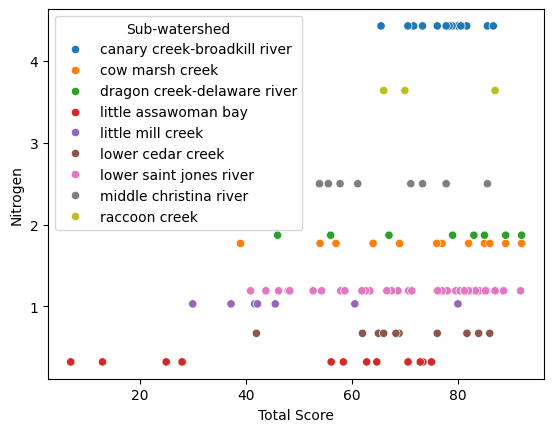

In [26]:
import seaborn as sns

sns.scatterplot(x='Total Score', y='N', hue='Sub-watershed', data=overlap).set_ylabel("Nitrogen")
plt.show()

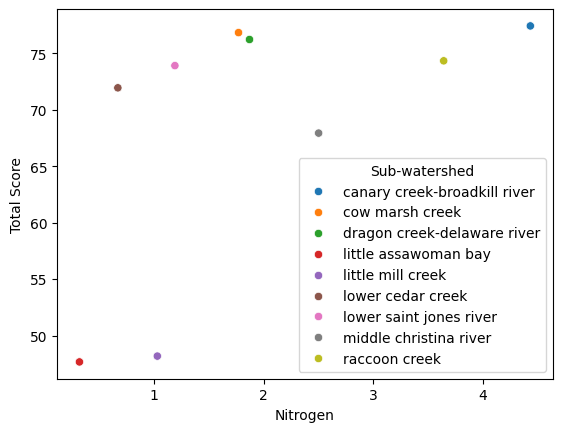

In [27]:
sns.scatterplot(x='N', y='Total Score', hue='Sub-watershed', data=TS_ave).set_xlabel("Nitrogen")
plt.show()

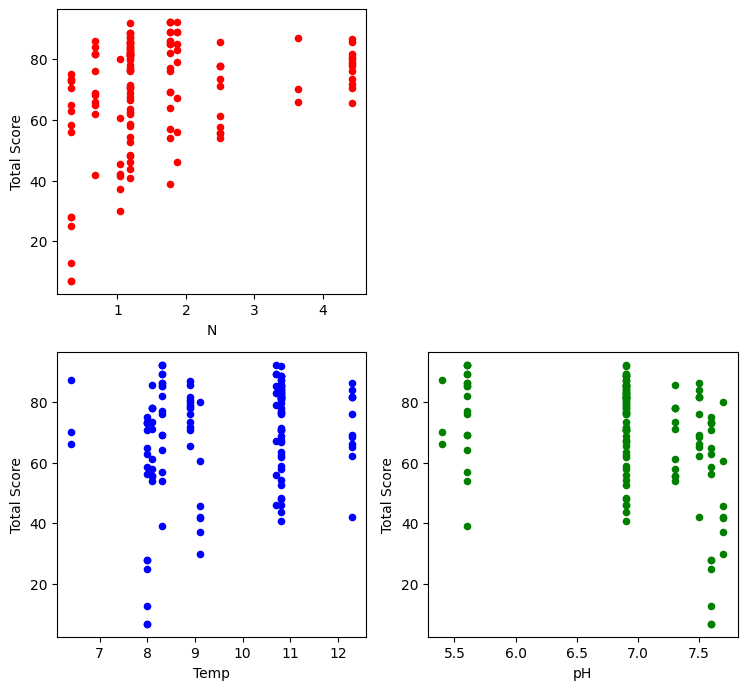

In [28]:
import matplotlib.pyplot as plt

# Plotting all features against TS
plt.figure(figsize=(15, 10))

ax = plt.subplot(3, 4, 1)
overlap.plot('N', 'Total Score', 'scatter', ax=ax, color='Red')
plt.xlabel('N')
plt.ylabel('Total Score')

ax = plt.subplot(3, 4, 5)
overlap.plot('Temp', 'Total Score', 'scatter', ax=ax, color='Blue')
plt.xlabel('Temp')
plt.ylabel('Total Score')

ax = plt.subplot(3, 4, 6)
overlap.plot('pH', 'Total Score', 'scatter', ax=ax, color='Green')
plt.xlabel('pH')
plt.ylabel('Total Score')

plt.tight_layout()
plt.show()

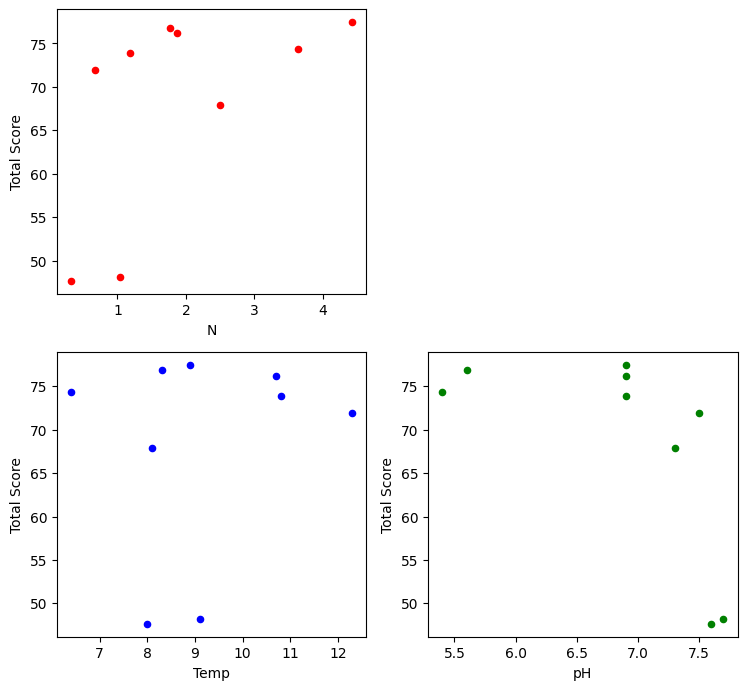

In [29]:
# Plotting all features against TS
plt.figure(figsize=(15, 10))

ax = plt.subplot(3, 4, 1)
TS_ave.plot('N', 'Total Score', 'scatter', ax=ax, color='Red')
plt.xlabel('N')
plt.ylabel('Total Score')

ax = plt.subplot(3, 4, 5)
TS_ave.plot('Temp', 'Total Score', 'scatter', ax=ax, color='Blue')
plt.xlabel('Temp')
plt.ylabel('Total Score')

ax = plt.subplot(3, 4, 6)
TS_ave.plot('pH', 'Total Score', 'scatter', ax=ax, color='Green')
plt.xlabel('pH')
plt.ylabel('Total Score')

plt.tight_layout()
plt.show()

## Exploratory

In [30]:
num_vars = ['N', 'pH', 'Temp', "Total Score"]
TS_ave[num_vars].corr()

,N,pH,Temp,Total Score
N,1.000000,-0.515925,-0.465387,0.564454
pH,-0.515925,1.000000,0.488525,-0.612524
Temp,-0.465387,0.488525,1.000000,0.187370
Total Score,0.564454,-0.612524,0.187370,1.000000


## Linear Regression

In [115]:
# multilinear regression
from sklearn.model_selection import train_test_split

# Select the features (independent variables)
vars = ['N', 'pH', 'Temp']
X1 = TS_ave[vars]

# Select the target variable (dependent variable)
y1 = TS_ave["Total Score"]

# Split the data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)

In [116]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a Linear Regression model
model_multivariate = LinearRegression()

# Fit the model to the training data
model1 = model_multivariate.fit(X1_train, y1_train)

# Make predictions on the testing data
y1_pred_test = model_multivariate.predict(X1_test)

# Evaluate the model
mse1 = mean_squared_error(y1_test, y1_pred_test)
r21 = r2_score(y1_test, y1_pred_test)

print(f"Mean Squared Error: {mse1}")
print(f"R-squared: {r21}")

# Print the coefficients and intercept
print("Coefficients:", list(zip(vars, model1.coef_)))
print("Intercept:", model1.intercept_)

Mean Squared Error: 37.78591697890038
R-squared: 0.7365366284660853
Coefficients: [('N', 4.465344464882963), ('pH', -9.476481677886177), ('Temp', 5.332267420446575)]
Intercept: 75.55520122450491


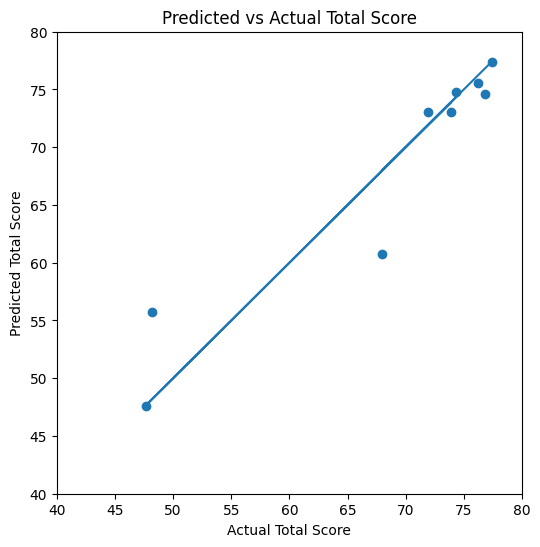

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
# Plot predicted vs actual total score
plt.scatter(y1, model_multivariate.predict(X1))
plt.xlabel("Actual Total Score")
plt.ylabel("Predicted Total Score")
plt.title("Predicted vs Actual Total Score")
plt.plot(y1, y1)
plt.xlim(40, 80)
plt.ylim(40, 80)
plt.show()

## Linear Regression Restricted

In [118]:
X2 = TS_ave[vars]

# Select the target variable (dependent variable)
y2 = TS_ave['Total Score']

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

# Create a Linear Regression model
model_multivariate_restricted = LinearRegression()

# Fit the model to the training data
model2 = model_multivariate_restricted.fit(X2_train, y2_train)

# Make predictions on the testing data
y2_pred_test = model_multivariate_restricted.predict(X2_test)

# Evaluate the model
mse2 = mean_squared_error(y2_test, y2_pred_test)
r22 = r2_score(y2_test, y2_pred_test)

print(f"Mean Squared Error: {mse2}")
print(f"R-squared: {r22}")

# Print the coefficients and intercept
print("Coefficients:", list(zip(vars, model2.coef_)))
print("Intercept:", model2.intercept_)

Mean Squared Error: 95.60875067523229
R-squared: 0.3357716161585108
Coefficients: [('N', 5.586273541012476), ('pH', -14.26288888890248), ('Temp', 7.496036047919422)]
Intercept: 83.95715235751778


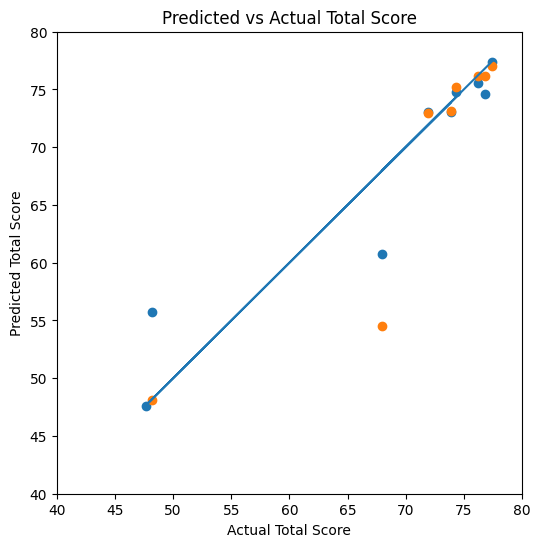

In [119]:
plt.figure(figsize=(6, 6))
# Plot predicted vs actual total score
plt.scatter(y1, model_multivariate.predict(X1))
plt.scatter(y2, model_multivariate_restricted.predict(X2))
plt.xlabel("Actual Total Score")
plt.ylabel("Predicted Total Score")
plt.title("Predicted vs Actual Total Score")
plt.plot(y1, y1)
plt.xlim(40, 80)
plt.ylim(40, 80)
plt.show()

## Random Forest

In [120]:
from sklearn.ensemble import RandomForestRegressor

X3 = TS_ave[vars]

# Select the target variable (dependent variable)
y3 = TS_ave['Total Score']

# Split the data into training and testing sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3)

# Create RF model
model = RandomForestRegressor(n_estimators = 100, max_depth = 3, random_state = 22)

model3 = model.fit(X3_train, y3_train)

# Make predictions on the testing data
y3_pred_test = model_multivariate_restricted.predict(X3_test)

# Evaluate the model
mse3 = mean_squared_error(y3_test, y3_pred_test)
r23 = r2_score(y3_test, y3_pred_test)

print(f"Mean Squared Error: {mse3}")
print(f"R-squared: {r23}")


Mean Squared Error: 36.191172240964725
R-squared: 0.7460340244700197


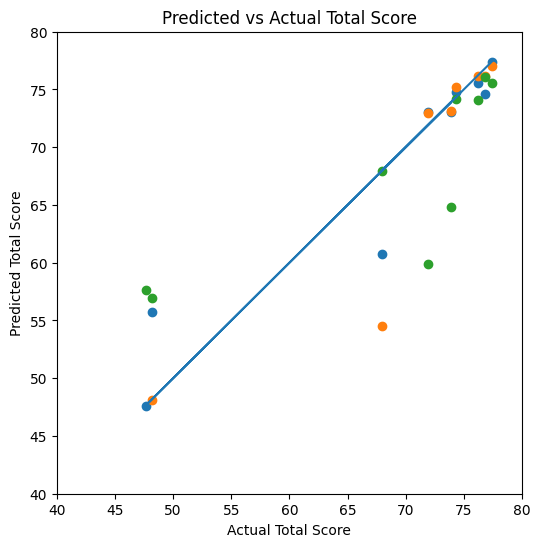

In [121]:
plt.figure(figsize=(6, 6))
# Plot predicted vs actual total score
plt.scatter(y1, model_multivariate.predict(X1))
plt.scatter(y2, model_multivariate_restricted.predict(X2))
plt.xlabel("Actual Total Score")
plt.ylabel("Predicted Total Score")
plt.title("Predicted vs Actual Total Score")
plt.plot(y1, y1)
plt.xlim(40, 80)
plt.ylim(40, 80)
plt.scatter(y3, model3.predict(X3))

plt.show()